# ABALONE YEARS PREDICTION

Abalone is the common name in the US for *Haliotis*, other terms are Paua (NZ) or Omer (UK). They all refer to a type molluscs with big shells <br>
The aim of this notebook is to predict the age of abalone from physical measurements, by working in different scenarios. The age (in years) is obtained by adding 1.5 to the number of rings (last column of the dataset.

## Atribute selection with PCA

Libraries import

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn import tree
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
from sklearn import decomposition
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

Load and split the dataset

In [2]:
Abalone = pd.read_csv("abalone.csv", sep=",", decimal=".")
X = Abalone.iloc[:,:-1]
y = Abalone.iloc[:,-1]

In [3]:
X.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055


In [4]:
y.head()

0    15
1     7
2     9
3    10
4     7
Name:  Rings, dtype: int64

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=33)

In [4]:
# Get list of categorical attributes

s = (X.dtypes == 'object')
object_cols = list(s[s].index)
print(object_cols)

['Sex']


Turn the categorical attribute into several numerical attributes, to be able to process the data with Scikit Learn models

In [5]:
from sklearn.preprocessing import OneHotEncoder

Encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
Encoder_train = pd.DataFrame(Encoder.fit_transform(X_train[object_cols]))
Encoder_test = pd.DataFrame(Encoder.fit_transform(X_test[object_cols]))

# Put back the index
Encoder_train.index = X_train.index
Encoder_test.index = X_test.index

# Remove original categorical attributes
num_X_train = X_train.drop(object_cols, axis=1)
num_X_test = X_test.drop(object_cols, axis=1)

# Add the one-hot encoded columns
Encoded_X_train = pd.concat([num_X_train, Encoder_train], axis=1)
Encoded_X_test = pd.concat([num_X_test, Encoder_test], axis=1)

In [21]:
Encoded_X_train.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,0,1,2
2248,0.360,0.270,0.090,0.2225,0.0830,0.0530,0.0750,0.0,0.0,1.0
1966,0.665,0.500,0.150,1.2475,0.4625,0.2955,0.3595,1.0,0.0,0.0
2760,0.550,0.430,0.145,0.7120,0.3025,0.1520,0.2250,0.0,1.0,0.0
20,0.355,0.280,0.095,0.2455,0.0955,0.0620,0.0750,0.0,0.0,1.0
838,0.480,0.365,0.135,0.6395,0.2945,0.1130,0.1750,1.0,0.0,0.0


In [22]:
Encoded_X_test.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,0,1,2
2806,0.675,0.525,0.170,1.7110,0.8365,0.3520,0.4750,1.0,0.0,0.0
2251,0.600,0.485,0.175,1.2675,0.4995,0.2815,0.3800,0.0,0.0,1.0
3771,0.575,0.450,0.145,0.7950,0.3640,0.1505,0.2600,0.0,1.0,0.0
3819,0.570,0.450,0.140,0.9275,0.4770,0.1605,0.2515,0.0,0.0,1.0
1690,0.625,0.500,0.170,1.0985,0.4645,0.2200,0.3540,0.0,0.0,1.0


Because PCA is affected by standarization, it is necessary to scale the attributes before applying PCA

In [6]:
scaler = StandardScaler()

# First fit the training set only

scaler.fit(Encoded_X_train)

# Then apply transform to train and test sets

Encoded_X_train = scaler.transform(Encoded_X_train)
Encoded_X_test = scaler.transform(Encoded_X_test)

In [33]:
print(Encoded_X_train.shape)

(2923, 10)


Let's use the maximum number of PCA components for the moment(which implies 10 PCA components)

In [7]:
pca_init = decomposition.PCA(n_components=10)
pca_init.fit(Encoded_X_train)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Let´s see how much variance explains each of the ten components. It´s clear to see that just the four first components alone explain more than 90%. This is because PCA procedure orders the components from the most important to the least important 

In [8]:
pca_init.explained_variance_ratio_

array([6.90244196e-01, 1.51438414e-01, 9.11817285e-02, 3.07036500e-02,
       1.65957041e-02, 1.14532385e-02, 6.57433451e-03, 1.13919709e-03,
       6.69537055e-04, 8.71620317e-33])

This can be seen graphycally as well

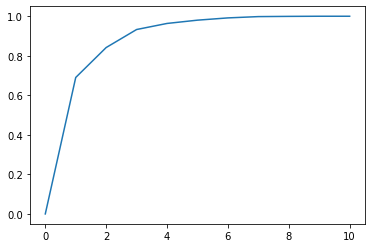

In [9]:
a = np.array([0])
concat = np.concatenate((a, pca_init.explained_variance_ratio_), axis=0)
accumulated_variance = np.cumsum(concat)
plt.plot(accumulated_variance)
plt.show()

Therefore, let's compute just 4 PCA components and apply them to train and test. 

In [10]:
pca_init = decomposition.PCA(n_components=4)
pca_init.fit(Encoded_X_train)
X_train_red = pca_init.transform(Encoded_X_train)
X_test_red = pca_init.transform(Encoded_X_test)

### Tree Regressor

Now, we can apply a regression tree model to the new, reduced, training set, and test it on the transformed test set

In [11]:
clf = tree.DecisionTreeRegressor(random_state=0)
clf = clf.fit(X_train_red, y_train)

In [12]:
y_train_pred = clf.predict(X_train_red)
y_pred = clf.predict(X_test_red)
print ("MAE for the training set using 3 pca is {}".format(mean_absolute_error(y_train, y_train_pred)))
print ("MAE for the test set using 3 pca is {}".format(mean_absolute_error(y_test, y_pred)))

MAE for the training set using 3 pca is 0.0
MAE for the test set using 3 pca is 2.3309409888357258


It is possible to reduce the dimesion of the problem from 10 to 4, however, while obtaining a MAE of 2.3 approximately. Do not forget that we are predicting  the age of the abalone (rings on the shell plus 1.5), so the unit of MAE is years

Let´s see what would happen if we use all the original attributes

In [13]:
clf = tree.DecisionTreeRegressor(random_state=0)
clf = clf.fit(Encoded_X_train, y_train)
y_train_pred = clf.predict(Encoded_X_train)
y_pred = clf.predict(Encoded_X_test)
print ("Accuracy for the training set using all the attributes is {}".format(mean_absolute_error(y_train, y_train_pred)))
print ("Accuracy for the test set using all the attributes is {}".format(mean_absolute_error(y_test, y_pred)))

Accuracy for the training set using all the attributes is 0.0
Accuracy for the test set using all the attributes is 2.148325358851675


MAE is pretty similar using 6 more attributes, which means that attribute selection with PCA works reasonably well (with a tree regressor). In practical terms, the years of abalones are predicted just with 3 attributes, which means that in the case of large dataset (big data approach), the number of values will be reduced in a 60%, thus optimizing the process substantially.

As, the attribute reduction seems to work pretty well, let´s try it now with a different model. A Random Forest.

### Random Forest Regressor

In [14]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(random_state=0)
clf = clf.fit(X_train_red, y_train)
y_train_pred = clf.predict(X_train_red)
y_pred = clf.predict(X_test_red)
print ("Accuracy for the training set using 3 pca is {}".format(mean_absolute_error(y_train, y_train_pred)))
print ("Accuracy for the test set using 3 pca is {}".format(mean_absolute_error(y_test, y_pred)))

Accuracy for the training set using 3 pca is 0.698323640095792
Accuracy for the test set using 3 pca is 1.9051834130781502


C:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The increase in test accuracy using 4 components in a regressor tree versus random forest it is not very significative (2.33 vs 1.90 years). However the training accuracy has decreased (0 vs 0.69 years)

In [15]:
clf = RandomForestRegressor(random_state=0)
clf = clf.fit(Encoded_X_train, y_train)
y_train_pred = clf.predict(Encoded_X_train)
y_pred = clf.predict(Encoded_X_test)
print ("Accuracy for the training set using 3 pca is {}".format(mean_absolute_error(y_train, y_train_pred)))
print ("Accuracy for the test set using 3 pca is {}".format(mean_absolute_error(y_test, y_pred)))

Accuracy for the training set using 3 pca is 0.6207321245295928
Accuracy for the test set using 3 pca is 1.6453748006379587


C:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


However, when using all the attributes, the changes in test accuracy is slightly more relevant if regressor tree is compared with a random forest (2.14 vs 1.64 years)

### Tunning the number of PCA

The number of PCA components can also be considered as a hyper-parameter, and it is possible to use a pipeline in order to select the right number of components. Let´s use that approach, so results can be analyzed later on

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [17]:
pca = decomposition.PCA()

# Define the paramter grid with the number of components
# to be used by PCA from 1 to 10
param_grid = {'attribute_selection__n_components': range(1,11)}

clf = Pipeline([
    ('attribute_selection', pca),
    ('tree', tree.DecisionTreeRegressor(random_state=0))
])

optPcaTree = GridSearchCV(clf, 
                              param_grid, 
                              cv=5,
                              n_jobs=1,
                              verbose=1,
                              scoring='neg_mean_absolute_error')

# Fit is done with the complete training set 

optPcaTree.fit(Encoded_X_train, y_train) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('attribute_selection',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('tree',
                                        DecisionTreeRegressor(criterion='mse',
                                                              max_depth=None,
                                                              max_features=None,
                                                              max_leaf_nodes=None,
                                                              min_impurity_decrease=0.0,
                                              

In [18]:
print (optPcaTree.best_params_, -optPcaTree.best_score_)

{'attribute_selection__n_components': 10} 2.041737940472118


The optimal number of PCA components for the tree model is equal to 10 (the maximum possible value). So the hyper-parameter tunning of PCA, results on larger number of attributes than "selecting" manually the minimum number of attributes with maximum variance explained

In [19]:
pca = decomposition.PCA()

# Define the paramter grid with the number of components
# to be used by PCA from 1 to 10
param_grid = {'attribute_selection__n_components': range(1,11)}

clf = Pipeline([
    ('attribute_selection', pca),
    ('forest', RandomForestRegressor(random_state=0))
])

optPcaForest = GridSearchCV(clf, 
                              param_grid, 
                              cv=5,
                              n_jobs=1,
                              verbose=1,
                              scoring='neg_mean_absolute_error')

# Fit is done with the complete training set 

optPcaForest.fit(Encoded_X_train, y_train) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", Fu

C:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\forest

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('attribute_selection',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('forest',
                                        RandomForestRegressor(bootstrap=True,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                     

In [20]:
print (optPcaForest.best_params_, -optPcaForest.best_score_)

{'attribute_selection__n_components': 9} 1.5432774546698598


The scenario is analogous to the previous one with a tree regressor, but in this ocassion the number of dimensions is equal to 9, however the prediction of how many years is the most accurate one.

### Summary

|**Model**|**Tunning of PCA**|**Number of components**|**Test MAE**|
|---------|------------------|------------------------|-------|
|Tree Regressor|No|3|2.33|
|Random Forest Regressor|No|3|1.90|
|Tree Regressor|Yes|10|2.04|
|Random Forest Regressor|Yes|9|1.54|